In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image

In [ ]:
! apt install tesseract-ocr
! apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtesseract-dev is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
! pip install Pillow
! pip install pytesseract

     |████████████████████████████████| 4.3 MB 4.8 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import re
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image
from pytesseract import Output
from prettytable import PrettyTable

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  after removing the cwd from sys.path.


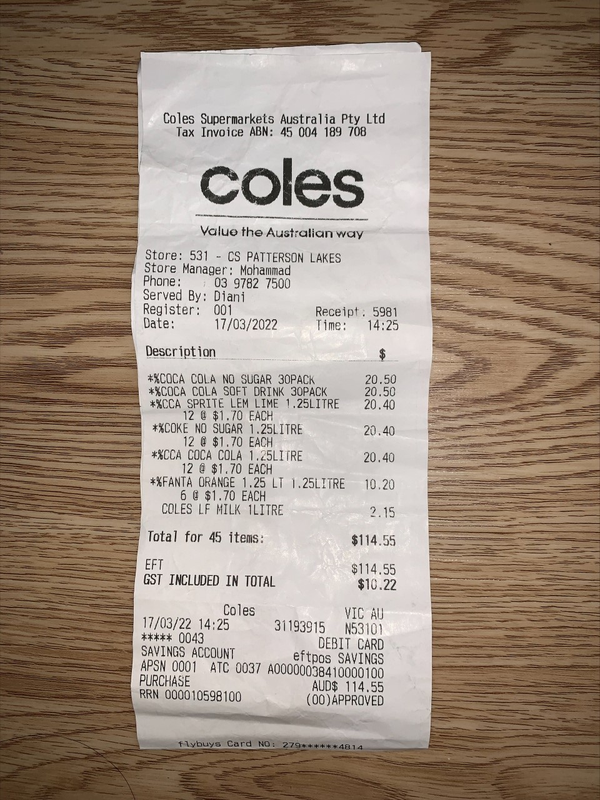

In [ ]:
# Sample file out of the dataset
file_name = '/content/drive/MyDrive/coles.jpg'
img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img

In [ ]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [ ]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [ ]:
image = cv2.imread(file_name)
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

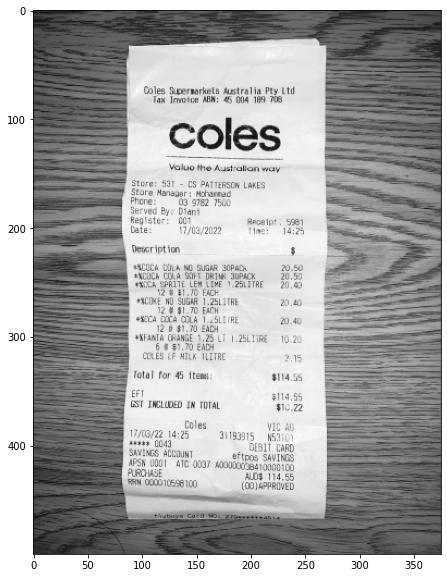

In [ ]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

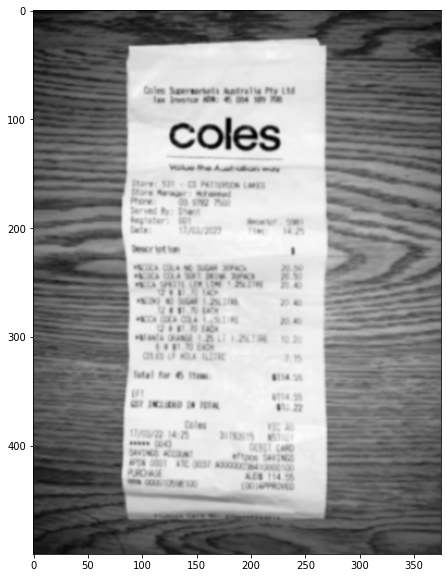

In [ ]:
# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

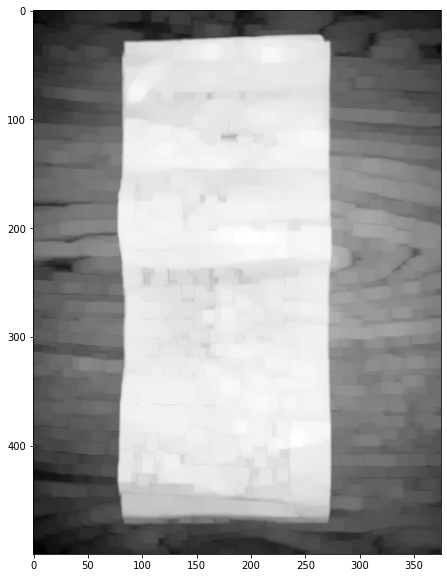

In [ ]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

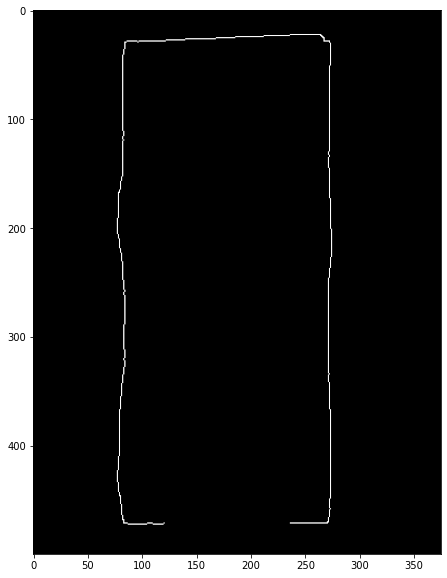

In [ ]:
edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
plot_gray(edged)

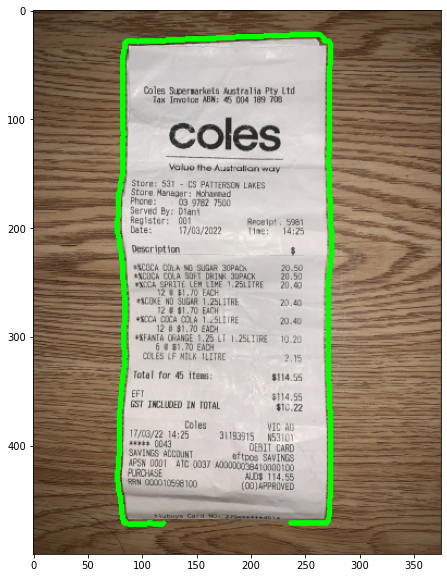

In [ ]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

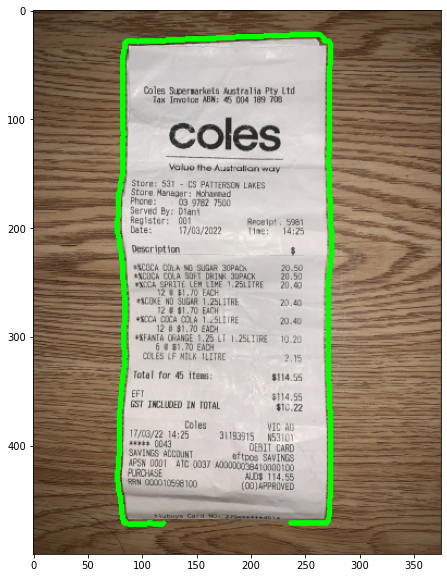

In [ ]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [ ]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

In [ ]:
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

In [ ]:
get_receipt_contour(largest_contours)

In [ ]:
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

error: ignored

In [ ]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [ ]:
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

In [ ]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

AttributeError: ignored

In [ ]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

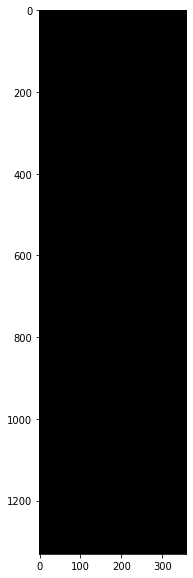

In [ ]:
result = bw_scanner(scanned)
image = bw_scanner(scanned)
plot_gray(result)